In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !unzip drive/My\ Drive/tiny-imagenet-200

In [1]:
import os

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras_preprocessing import image

from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

Using TensorFlow backend.


In [0]:
train_img_gen = image.ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.4,
    zoom_range = 0.3,
    horizontal_flip = True
)

# we don't need to do augmentation for test data
test_img_gen = image.ImageDataGenerator(
    rescale = 1/255.0
)

In [0]:
train_gen = train_img_gen.flow_from_directory(
    'tiny-imagenet-200/train/',
    target_size = ((224, 224)),
    batch_size = 1024,
    class_mode = 'categorical'

)
test_gen = test_img_gen.flow_from_directory(
    'tiny-imagenet-200/test/',
    target_size = ((224, 224)),
    batch_size = 512,
    class_mode = 'categorical'

)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 1 classes.


In [0]:
for (x, y) in train_gen:
  print(x.shape, y.shape)
  break

(1024, 224, 224, 3) (1024, 200)


In [0]:
# validation data processing, since it is different form

class_ids = train_gen.class_indices

def load_validation_data(target_size, number_of_classes):
  with open('tiny-imagenet-200/val/val_annotations.txt') as f:
    lines = f.readlines()
    m = len(lines)
    X = np.empty((m, *target_size, 3))
    Y = np.empty(m)
    
    for i, line in enumerate(lines):
      token = line.split()
      img_name = token[0]
      img_label = token[1]
      
      img_url = os.path.join('tiny-imagenet-200/val/images', img_name)
      
      img = image.load_img(img_url)
      img = img.resize(target_size)
      X[i, ] = np.array(img, dtype=np.float32)/255.0
      img.close()
      Y[i] = class_ids[img_label]
      
    return X, keras.utils.np_utils.to_categorical(Y)
      
    

In [0]:
x_val, y_val =  load_validation_data((224, 224), 200)

In [0]:
# print(x_val.shape, y_val.shape)

In [0]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')

In [0]:
batch_size = 256
nb_classes = 100
nb_epoch = 100
data_augmentation = True

# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

In [6]:
## cifar100 data prep
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169009152/169001437 [==============================] - 6s 0us/step


In [7]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [0]:
y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)

In [9]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 100)
(10000, 32, 32, 3) (10000, 100)


In [0]:
train_img_gen = image.ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.4,
    zoom_range = 0.3,
    horizontal_flip = True
)
test_img_gen = image.ImageDataGenerator(
    rescale = 1/255.0,
)

In [0]:
#### data augmentation
train_gen = train_img_gen.flow(
    x_train,
    y_train,
    batch_size = 512,

)
test_gen = test_img_gen.flow(
    x_test,
    y_test,
    batch_size = 512,

)

In [0]:
for (x, y) in train_gen:
  print(x.shape, y.shape)
  break

(512, 32, 32, 3) (512, 100)


In [0]:
datagen = image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False  # randomly flip images
)

In [0]:
datagen.fit(x_train)

In [0]:
# from google.colab import files
# files.upload()

Resnet Architecture

In [0]:
#model architecture
## download resenet from here https://github.com/raghakot/keras-resnet
import resnet


In [0]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)

In [0]:
model.summary()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# Fit the model on the batches generated by datagen.flow().
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test),
                        epochs=nb_epoch, verbose=1, max_q_size=100,
                        callbacks=[lr_reducer, early_stopper, csv_logger])

Epoch 1/100
195/195 [==============================] - 42s 217ms/step - loss: 4.0575 - acc: 0.1850 - val_loss: 3.8055 - val_acc: 0.2184
Epoch 2/100
195/195 [==============================] - 31s 157ms/step - loss: 3.3141 - acc: 0.2995 - val_loss: 3.3547 - val_acc: 0.2893
Epoch 3/100
195/195 [==============================] - 30s 154ms/step - loss: 2.9995 - acc: 0.3568 - val_loss: 3.0791 - val_acc: 0.3372
Epoch 4/100
195/195 [==============================] - 30s 154ms/step - loss: 2.7973 - acc: 0.3954 - val_loss: 3.0095 - val_acc: 0.3598
Epoch 5/100
195/195 [==============================] - 30s 154ms/step - loss: 2.6597 - acc: 0.4224 - val_loss: 3.0214 - val_acc: 0.3567
Epoch 6/100
195/195 [==============================] - 30s 154ms/step - loss: 2.5256 - acc: 0.4476 - val_loss: 2.8670 - val_acc: 0.3867
Epoch 7/100
195/195 [==============================] - 30s 154ms/step - loss: 2.4236 - acc: 0.4722 - val_loss: 2.9844 - val_acc: 0.3648
Epoch 8/100
195/195 [===========================

In [0]:
def plot_loss_accuracy():
  # plot loss
  print("training_loss =", hist.history['loss'][-1],  "   val_loss =", hist.history['val_loss'][-1])
  print("training_acc =", hist.history['acc'][-1]*100, "   val_acc =", hist.history['val_acc'][-1]*100)
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.plot(hist.history['loss'], label='training_loss')

  # plot accuracy
  plt.plot(hist.history['val_acc'], label='val_acc')
  plt.plot(hist.history['acc'], label='training_acc')
  plt.legend()
  plt.show()


training_loss = 0.7642893303088645    val_loss = 2.3662081531524657
training_acc = 92.2201672582697    val_acc = 56.03


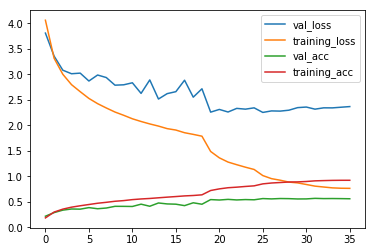

In [27]:
plot_loss_accuracy()